In [1]:
!pip install datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from string import punctuation
import torch
from torch import nn
import re
from math import log
from datasets import load_dataset_builder
from datasets import load_dataset


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.0 MB/s eta 0:00:00


In [8]:
# This cell clean the vader sentiment, removing words graded beetween -1 and 1 and setting negative grades to -1 and positive to 1

vader_lexicon = pd.read_csv("/content/vader_lexicon.csv", delimiter="\t", names=["symbols", "grade"], usecols=[0,1])
vader_lexicon.loc[vader_lexicon.grade >= 1].grade = 1
vader_lexicon.loc[vader_lexicon.grade <= -1].grade = -1
vader_lexicon = vader_lexicon[(vader_lexicon.grade == 1) | (vader_lexicon.grade == -1)]
vader_lexicon.set_index("symbols", inplace=True)
vader_lexicon

<ipython-input-8-b199027bafb2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_lexicon.loc[vader_lexicon.grade >= 1].grade = 1
<ipython-input-8-b199027bafb2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_lexicon.loc[vader_lexicon.grade <= -1].grade = -1


,grade
symbols,
/^:,-1.0
:p,1.0
:^\,-1.0
:^|,-1.0
;-),1.0
...,...
wimps,-1.0
wisenheimer,-1.0
worshiper,1.0


In [6]:
# Load the data, clean the text and merge all the different train validation and test datasets into one
dataset = load_dataset("imdb")

all_data = {}

def clean_data(text_data):
    text_data = text_data.str.lower()
    text_data = text_data.str.replace("[" + punctuation + "]( |$)", "", regex=True)
    return text_data

for type in dataset.keys():
        
    text_data = pd.Series(dataset[type]["text"])

    text_data = clean_data(text_data=text_data)
    all_data[type] = pd.concat([text_data, pd.Series(dataset[type]["label"])], axis=1)
    all_data[type].columns=["text", "label"]
    
    
data = all_data["train"]
data

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

,text,label
0,i rented i am curious-yellow from my video sto...,0
1,"""i am curiousyellowis a risible and pretentiou...",0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard's ma...,0
4,ohbrother...after hearing about this ridiculou...,0
...,...,...
24995,a hit at the time but now better categorised a...,1
24996,i love this movie like no otheranother time i ...,1
24997,this film and it's sequel barry mckenzie holds...,1
24998,'the adventures of barry mckenziestarted life ...,1


In [9]:

data_set = ["I don't really know where this came from, but this movie, which was very clearly created to be for kids, has some real material built around solid bones. And that wolf was genuinely unnerving.", "meh; i didn't love it. it lost my attention eventually."]
data_set = pd.DataFrame(data, columns=["text", "label"])
data_set["text"] = data_set["text"].str.lower()

def grade(word : str):
  """
  return the grade of the word given in parameter in the vader lexicon if exists or 0 if it is not in.
  """
  try:
    x = vader_lexicon.loc[word].grade
  except KeyError:
    x = 0
  return x

# Each line produce a part of the required vector.
# The next cells will produces plots of those to better understand the repartition od datas
data_set["word list"] = data_set["text"].apply(lambda text : re.split("[" + punctuation + " ]", text))
data_set["no?"] = data_set["word list"].apply(lambda word_list : "no" in word_list).astype("int")
data_set["pronoun"] = data_set["word list"].apply(lambda word_list : word_list.count("i") + word_list.count("you"))
data_set["!?"] = data_set["text"].str.contains("!").astype("int")
data_set["log(nb word)"] = data_set["word list"].apply(len).apply(np.log)
data_set["word list"] = data_set["word list"].apply(lambda word_list : [grade(word) for word in word_list])
data_set["good_mood"] = data_set["word list"].apply(lambda word_list : word_list.count(1))
data_set["bad_mood"] = data_set["word list"].apply(lambda word_list : word_list.count(-1))


data_set


,text,label,word list,no?,pronoun,!?,log(nb word),good_mood,bad_mood
0,i rented i am curious-yellow from my video sto...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,4,0,5.686975,0,0
1,"""i am curiousyellowis a risible and pretentiou...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,0,5.327876,0,0
2,if only to avoid making this type of film in t...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0,4.736198,0,0
3,this film was probably inspired by godard's ma...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,0,4.836282,0,0
4,ohbrother...after hearing about this ridiculou...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,8,1,5.897154,0,0
...,...,...,...,...,...,...,...,...,...
24995,a hit at the time but now better categorised a...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,4.564348,1,0
24996,i love this movie like no otheranother time i ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,6,1,5.393628,0,0
24997,this film and it's sequel barry mckenzie holds...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,0,4.955827,0,0
24998,'the adventures of barry mckenziestarted life ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,1,6.573680,1,0


array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

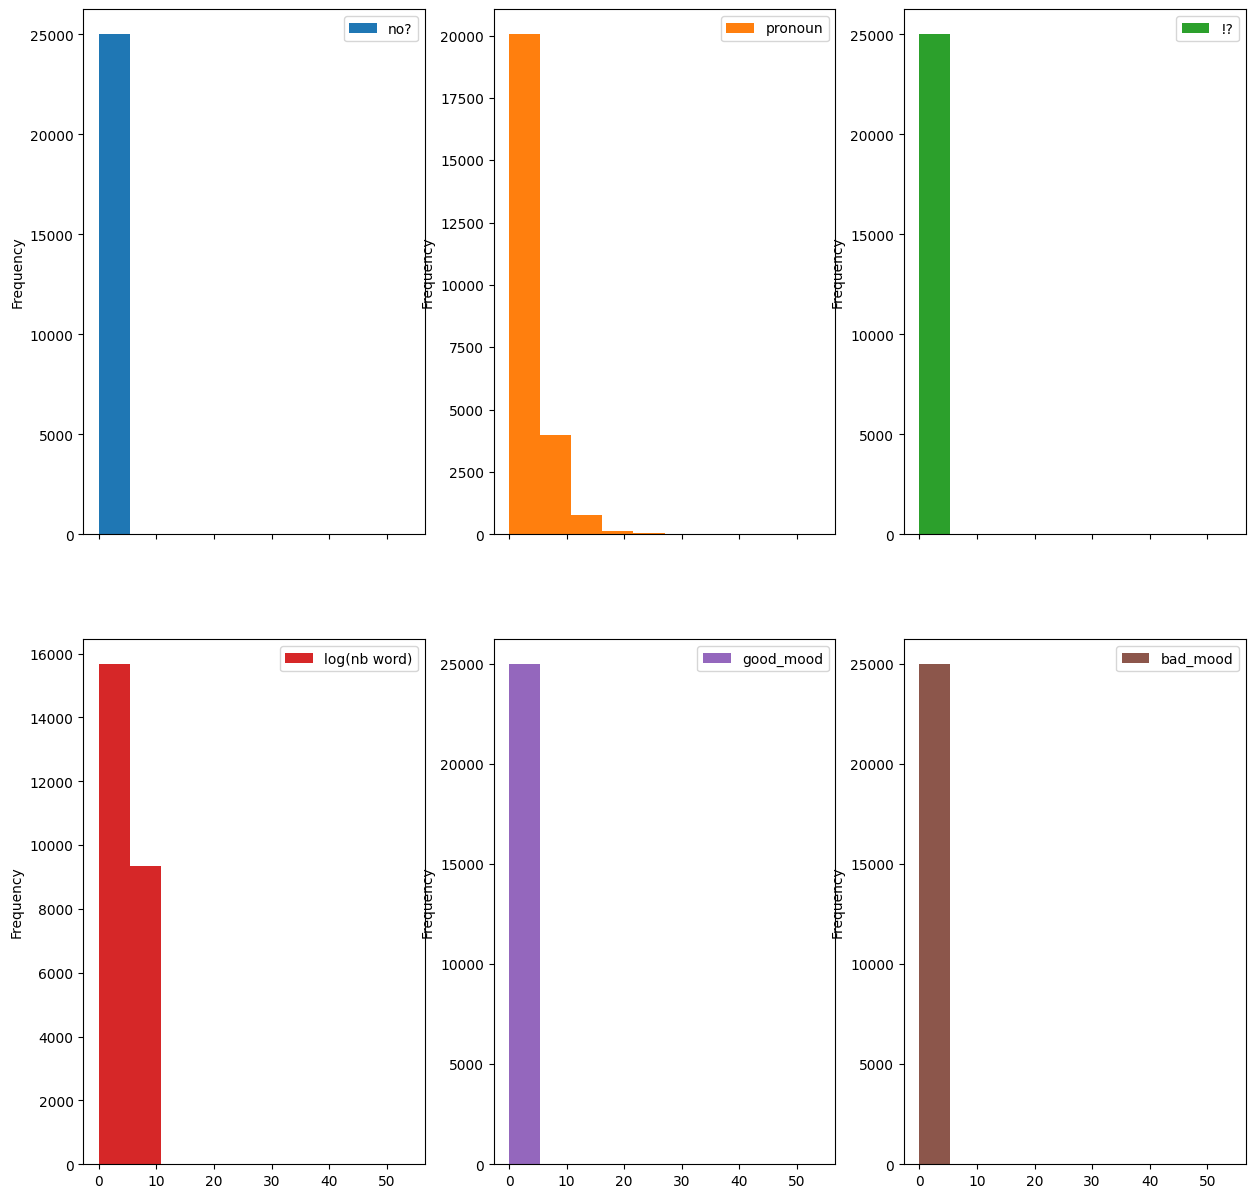

In [27]:
data_set.sort_values(by='good_mood', ascending=False, inplace=True)
data_set.drop('label', axis=1).plot.hist(subplots=True, layout=(2,3), figsize=(15,15))

In [ ]:
data_set.iloc[0].text

"there be very little doubt that hg wells is the most influential writer of the 20th century jules verne has some claim to be the father of science fiction but his stories were more adventure stories using marvellous inventions as plot devices wells was profound and brought subtext to his tales perhaps his greatest legacy is that there's very little if any evidence that people believed in life on other planets before the 20th century where as now many people including richard dawkins consider it a near certainty there's no evidence of this of course and one can't help wondering that is was wells who introduced this to human thinking undoubtedly it was wells that planted the seed .<br /><br />things to come was adapted by wells himself from his own novel it is rather obvious however that he is unable to tell the difference between the technicalities of writing novels and writing screenplays the dialouge is often laden heavy handed and unconvincing one case in point is the two pilots fro

In [39]:
data_set['!?'].value_counts()

0    20886
1     4114
Name: !?, dtype: int64

In [ ]:
df = pd.DataFrame()
df["x"] = data_set['good_mood']
df["y"] = data_set['log(nb word)']
df["label"] = data_set['label']
df.head()

,x,y,label
20654,10,5.961005,1
11621,7,6.896694,0
14170,7,6.910751,1
20639,6,6.390241,1
2406,6,6.298949,0


<Axes: xlabel='x', ylabel='y'>

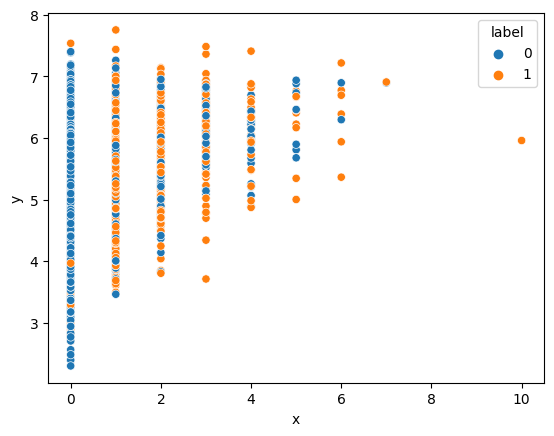

In [ ]:
sns.scatterplot(data=df, x="x", y="y", hue="label")

## Train, test, and validation split

We need a test set to evaluate our final model, and a validation set to make sure we don't overfit to the training data.

In [30]:
all_points = torch.tensor(data_set.drop(['text', 'word list', 'label'], axis=1).to_numpy(), dtype=torch.float32)
labels = torch.tensor(data_set['label'].to_numpy(), dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

## Logisitic regression classifier

In [31]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

## Training the model

In [32]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [33]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.7075, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6884, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6886, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6890, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6893, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6894, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6895, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6896, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6896, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 2.32 s, sys: 12.6 ms, total: 2.33 s
Wall time: 2.51 s


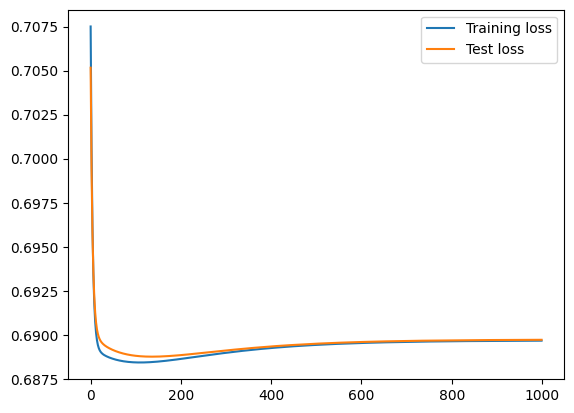

In [34]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [35]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.5435 0.5465 0.5544


In [ ]:
# Predicting new samples
model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32))

RuntimeError: ignored

In [40]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]

(tensor([[-0.0513, -0.0273, -0.0083,  0.0180,  0.0326, -0.0039]]),
 tensor([0.0017]))

## Training model, but better

The best practice with PyTorch is to return the logits and not the results of the activation function. Doing so allows to use an [implementation trick](https://en.wikipedia.org/wiki/LogSumExp) which gives better stability at training. The following code uses this trick. It removes the activation function from the model and uses the corresponding ...WithLogitsLoss function.

In [41]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [42]:
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [43]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.8020, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6963, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6922, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6910, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6904, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6901, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6899, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6898, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6898, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
CPU times: user 887 ms, sys: 7.98 ms, total: 895 ms
Wall time: 917 ms


Notice how the training was faster. This is due to the implementation trick.

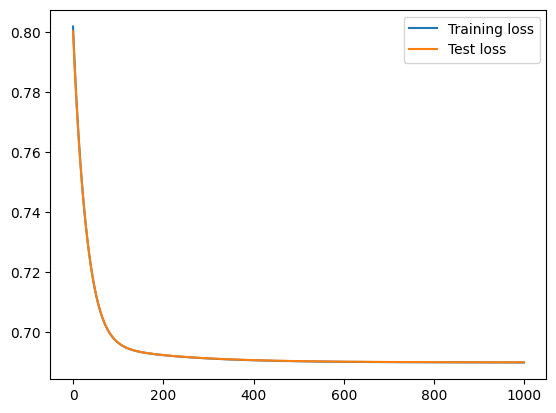

In [44]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [45]:
# Note that we need to use a sigmoid on the output now.
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.54275 0.546 0.5526


In [ ]:
# Predicting new samples, we need to use a sigmoid on top of the output.
torch.sigmoid(model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32)))

tensor([[0.1588],
        [0.8418]], grad_fn=<SigmoidBackward0>)